In [337]:
import math
from PIL import Image
import numpy as np

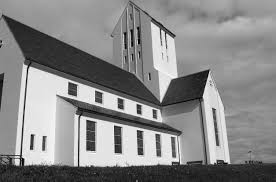

In [338]:
image = Image.open('image1.jfif').convert('L')
image

In [339]:
image = np.array(image)
image

array([[150, 150, 150, ..., 163, 163, 163],
       [149, 150, 150, ..., 163, 163, 163],
       [149, 149, 149, ..., 162, 162, 162],
       ...,
       [ 41,  31,  47, ...,  44,  47,  49],
       [ 47,  31,  35, ...,  32,  35,  38],
       [ 50,  36,  28, ...,  30,  33,  36]], dtype=uint8)

In [340]:
def neighbours1D(row, px_ix, radius):
    ns = []
    for nix in range(-radius, radius + 1):
        if (px_ix + nix) < 0:  # wrap low
            nix = -nix
        if (px_ix + nix) >= len(row):  # wrap high
            nix = -nix
        ns.append(row[px_ix + nix])

    return np.array(ns)

def neighbours2D(arr, px_ix, radius):
    ns = []
    for nix_y in range(-radius, radius + 1):
        if (px_ix[0] + nix_y) < 0:  # wrap low
            nix_y = -nix_y
        if (px_ix[0] + nix_y) >= len(arr):  # wrap high
            nix_y = -nix_y

        row = arr[px_ix[0] + nix_y]
        ns.append(neighbours1D(row, px_ix[1], radius))

    return np.array(ns)

In [341]:
def convolve1D(arr, kernel):
    output_shape = (arr.shape[0] - kernel.shape[0] + 1, )
    output = np.zeros(output_shape)

    for row_ix in range(output_shape[0]):
        output[row_ix] = np.sum(np.multiply(kernel, arr[row_ix:row_ix + kernel.shape[0]]))

    return output

def convolve2D(arr, kernel):
    output_shape = (arr.shape[0] - kernel.shape[0] + 1, arr.shape[1] - kernel.shape[1] + 1)
    output = np.zeros(output_shape)

    for row_ix in range(output_shape[0]):
        for col_ix in range(output_shape[1]):
            output[row_ix, col_ix] = np.sum(np.multiply(kernel, arr[row_ix:row_ix + kernel.shape[0], col_ix:col_ix + kernel.shape[1]]))

    return output

In [342]:
def gaussianWeights(radius, sigma):
    x = np.arange(-radius, radius + 1)
    weights = np.exp(-(x ** 2) / (2 * (sigma ** 2)))
    weights = np.array([w / sum(weights) for w in weights])

    return weights

In [343]:
def gaussianBlur1D(image_arr, radius, sigma):
    weights = gaussianWeights(radius, sigma)

    output = np.zeros((image_arr.shape[0], image_arr.shape[1] - (2 * radius)))
    for row_ix in range(len(image_arr)):
        output[row_ix] = convolve1D(image_arr[row_ix], weights)

    return output

def gaussianBlur(image_arr, radius, sigma):
    return gaussianBlur1D(gaussianBlur1D(image_arr, radius, sigma).transpose(), radius, sigma).transpose()

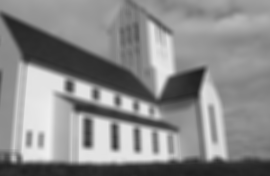

In [344]:
blurred = gaussianBlur(image, 3, 3)
Image.fromarray(blurred).convert('L').save('blurred.png')
Image.fromarray(blurred).convert('L')

In [345]:
Gx = np.array([1, 0, -1, 2, 0, -2, 1, 0, -1]).reshape((3, 3))
Gy = np.array([1, 2, 1, 0, 0, 0, -1, -2, -1]).reshape((3, 3))
def sobel(image_arr):
    return convolve2D(image_arr, Gx), convolve2D(image_arr, Gy)

In [346]:
def walkHysteresis(x, y, potential_edges, lows, edges):
    if edges[x, y] == 1:
        return
    if (x, y) in lows:
        edges[x, y] = 255.

        for target_x in range(x - 1, x + 2):
            if target_x < 0 or target_x > edges.shape[0]:
                continue

            for target_y in range(y - 1, y + 2):
                if target_y < 0 or target_y > edges.shape[1]:
                    continue
                potential_edges.append((target_x, target_y))

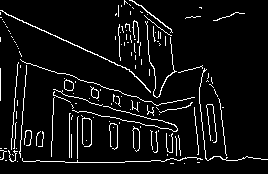

In [347]:
def canny(image_arr, low, high, sigma):
    # gaussian blur to reduce noise
    image_arr = image_arr[:]
    image_arr = gaussianBlur(image_arr, 3, sigma)

    # determine gradients via sobel
    gradient_x, gradient_y = sobel(image_arr)
    image_arr = image_arr[1:len(image_arr) - 2, 1:len(image_arr[0]) - 2]

    # compute gradient magnitudes and angles
    gradient_mag = np.zeros(gradient_x.shape)
    gradient_angle = np.zeros(gradient_x.shape)
    for row_ix in range(gradient_x.shape[0]):
        for col_ix in range(gradient_x.shape[1]):
            gx = gradient_x[row_ix, col_ix]
            gy = gradient_y[row_ix, col_ix]
            gradient_mag[row_ix, col_ix] = math.hypot(gx, gy)
            gradient_angle[row_ix, col_ix] = math.degrees(math.atan2(gy, gx))

    # trim off low values, sort into high/low
    edges = np.zeros(gradient_angle.shape)
    lows = []
    for row_ix in range(gradient_angle.shape[0]):
        for col_ix in range(gradient_angle.shape[1]):
            if gradient_mag[row_ix, col_ix] < low:
                gradient_mag[row_ix, col_ix] = 0.
                gradient_angle[row_ix, col_ix] = 0.
            elif gradient_mag[row_ix, col_ix] > high:
                edges[row_ix, col_ix] = 255.
            else:
                lows.append((row_ix, col_ix))

    # non-maximum suppression, by rounding angles
    for row_ix in range(gradient_mag.shape[0]):
        for col_ix in range(gradient_mag.shape[1]):
            # round angle to determine which neighbours to compare to
            angle = gradient_angle[row_ix, col_ix]
            if -22.5 <= angle < 22.5 or angle < -157.5 or angle >= 157.5:
                to_compare = ((row_ix, col_ix - 1), (row_ix, col_ix + 1))
            elif 22.5 <= angle < 67.5 or -157.5 <= angle < + -112.5:
                to_compare = ((row_ix - 1, col_ix - 1), (row_ix + 1, col_ix + 1))
            elif 67.5 <= angle < 112.5 or -112.5 <= angle < 67.5:
                to_compare = ((row_ix - 1, col_ix), (row_ix + 1, col_ix))
            else:
                to_compare = ((row_ix - 1, col_ix + 1), (row_ix + 1, col_ix - 1))

            # sanitize to_compare to within bounds
            if to_compare[0][0] < 0 or to_compare[0][0] >= edges.shape[0] or \
                to_compare[0][1] < 0 or to_compare[0][1] >= edges.shape[1]:
                to_compare = ((row_ix, col_ix), to_compare[1])
            if to_compare[1][0] < 0 or to_compare[1][0] >= edges.shape[0] or \
                to_compare[1][1] < 0 or to_compare[1][1] >= edges.shape[1]:
                to_compare = (to_compare[0], (row_ix, col_ix))

            # ensure gradient_mag is larger than neighbours
            if gradient_mag[row_ix, col_ix] < gradient_mag[to_compare[0]] or \
                gradient_mag[row_ix, col_ix] < gradient_mag[to_compare[1]]:
                edges[row_ix, col_ix] = 0.

    # perform hysteresis thresholding
    for row_ix in range(edges.shape[0]):
        for col_ix in range(edges.shape[1]):
            if edges[row_ix, col_ix] == 1:
                potential_edges = [(row_ix, col_ix)]
                while len(potential_edges) > 0:
                    next_pixel = potential_edges.pop()
                    walkHysteresis(next_pixel[0], next_pixel[1], potential_edges, lows, edges)

    return edges

edges = canny(image, low=10, high=40, sigma=3)
Image.fromarray(edges).convert('1').save('edges.png')
Image.fromarray(edges).convert('1')

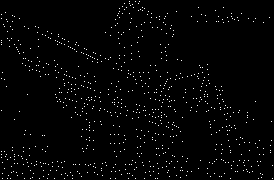

In [348]:
def harris(image_arr, threshold, k=0.06):
    gaussWeights = np.outer(gaussianWeights(1, 1), gaussianWeights(1, 1))
    Ix, Iy = sobel(image_arr)
    Ixx = Ix * Ix
    Ixy = Ix * Iy
    Iyy = Iy * Iy

    window_size = 3
    trim = window_size // 2

    output_shape = (image_arr.shape[0] - window_size + 1, image_arr.shape[1] - window_size + 1)
    potentialCorners = {}
    for row_ix in range(trim, output_shape[0] - trim):
        for col_ix in range(trim, output_shape[1] - trim):
            # construct M
            M = np.zeros((3, 3))
            for Mx in range(3):
                for My in  range(3):
                    M[0, 0] += gaussWeights[Mx, My] * Ixx[row_ix - trim + Mx, col_ix - trim + My]
                    M[0, 1] += gaussWeights[Mx, My] * Ixy[row_ix - trim + Mx, col_ix - trim + My]
                    M[1, 0] += gaussWeights[Mx, My] * Ixy[row_ix - trim + Mx, col_ix - trim + My]
                    M[1, 1] += gaussWeights[Mx, My] * Iyy[row_ix - trim + Mx, col_ix - trim + My]

            # compute eigenvalues => R (score)
            eigs = np.linalg.eigvals(M)
            det = eigs[0] * eigs[1]
            trace = eigs[0] + eigs[1]
            r = det - (k * (trace ** 2))

            # preserve corner data for now
            if r > threshold:
                potentialCorners[(row_ix, col_ix)] = r

    # non-maximum suppression
    corners = []
    def isHighest(x, y, r):  # for return-breaking out of nested loops
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                # skip self
                if dx == 0 and dy == 0:
                    continue
                # make sure local is higher than neighbours
                if (x + dx, y + dy) in potentialCorners:
                    if r < potentialCorners[(x + dx, y + dy)]:
                        return False
        return True

    for x, y in potentialCorners.keys():
        r = potentialCorners[(x, y)]
        if isHighest(x, y, r):
            corners.append((x, y))

    # construct output image
    output = np.zeros(output_shape)
    for x, y in corners:
        output[x, y] = 255

    return output

corners = harris(image, 100000, k=0.04)
Image.fromarray(corners).convert('1').save('corners.png')
Image.fromarray(corners).convert('1')